In [35]:
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm
from sae_lens import SAE
from src.judge import get_scores
from matplotlib import pyplot as plt
from src.visualize import visualize_score_plots
from transformers import AutoModelForCausalLM, AutoTokenizer

%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Оценка качества генераций

Модель для валидации

__deepseek-r1:8b__, https://ollama.com/library/deepseek-r1:8b

Системный промпт

```
You score texts generated by a language model based on the following criterion:\n
<criterion>.

You provide a score from 1 to 10.
The language model was given a prompt and generated the following text.
Evaluate the text based on the criterion. Output format should be JSON with the following fields: \"score\" (int)
```

Пользовательский промпт

```
Message content

Prompt:

Completion:
"""
<genarated-text>
"""
```



In [2]:
torch.manual_seed(16)
torch.set_grad_enabled(False)

In [3]:

model_name = "google/gemma-2-2b-it"

model = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
conversation = [{"role": "user", "content": "Who are you?"}]
chat = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
inputs = tokenizer.encode(chat, return_tensors="pt", add_special_tokens=True).to("mps")

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res-canonical",
    sae_id = "layer_20/width_16k/canonical",
    device = "mps"
)

def generate_with_sae(model,
                      sae: SAE,
                      layer: int,
                      feature_index: int,
                      alpha: float,
                      do_sample: bool,
                      temperature: float,
                      max_len: int,
                      repetition_penalty:float=1.0,
                      normalize_new_hidden=True):

    assert alpha >= 0

    def gather_act_hook(mod, inputs, outputs):

        h = outputs[0]

        try:

            h = sae.encode(h)
            steering = torch.zeros_like(h)
            steering[:, :, feature_index] = alpha

            if normalize_new_hidden:
                h_steer = h + steering
                h_steer = (h_steer / h_steer.norm(dim=-1, keepdim=True)) * h.norm(dim=-1, keepdim=True)
            else:
                h_steer = h + steering
        except:
            print("error")
            h_steer = outputs[0]

        h_steer = sae.decode(h_steer)

        return (h_steer,)

    hook = model.model.layers[layer].register_forward_hook(gather_act_hook)

    outputs = model.generate(inputs,
                             max_length=max_len,
                             temperature=temperature,
                             do_sample=do_sample,
                             repetition_penalty=repetition_penalty,
                             use_cache=False)
    hook.remove()

    return outputs


In [5]:
outputs = generate_with_sae(model,
                            sae,
                            layer=20,
                            feature_index=12082,
                            alpha=260.0,
                            do_sample=True,
                            temperature=0.5,
                            max_len=60,
                            repetition_penalty=1.0,
                            normalize_new_hidden=False)

You have set `use_cache` to `False`, but cache_implementation is set to hybrid. cache_implementation will have no effect.


In [6]:
tokenizer.decode(outputs[0], skip_special_tokens=False).split("<start_of_turn>model\n")[1]

'I am a medium-size, non-working, and non-social-media-friendly, \nCompanion Dog, \nI am a loyal, friendly, and loving companion for the best dog owner, \nI'

In [7]:
from tqdm import tqdm

non_normalized = {}

for alpha in tqdm(np.linspace(0, 500, 20)):
    outputs = generate_with_sae(model,
                            sae,
                            layer=20,
                            feature_index=12082,
                            alpha=alpha,
                            do_sample=True,
                            temperature=0.5,
                            max_len=60,
                            repetition_penalty=1.0,
                            normalize_new_hidden=False)

    non_normalized[alpha] = tokenizer.decode(outputs[0], skip_special_tokens=False).split("<start_of_turn>model\n")[1]

normalized = {}

for alpha in tqdm(np.linspace(0, 500, 20)):
    outputs = generate_with_sae(model,
                            sae,
                            layer=20,
                            feature_index=12082,
                            alpha=alpha,
                            do_sample=True,
                            temperature=0.5,
                            max_len=60,
                            repetition_penalty=1.0,
                            normalize_new_hidden=True)

    normalized[alpha] = tokenizer.decode(outputs[0], skip_special_tokens=False).split("<start_of_turn>model\n")[1]

100%|██████████| 20/20 [01:18<00:00,  3.94s/it]


In [104]:
import pandas as pd

In [8]:
pd.DataFrame({
    "alpha": non_normalized.keys(),
    "answers": non_normalized.values()
}).to_json("../answers/non_normalized_2.json")

In [9]:
pd.DataFrame({
    "alpha": normalized.keys(),
    "answers": normalized.values()
}).to_json("../answers/normalized_2.json")

In [11]:
def add_score_to_dataframe(df: pd.DataFrame, behavioral: str) -> pd.DataFrame:
    df_cp = df.copy()

    beh_score = []
    coh_score = []

    for i, row in tqdm(df_cp.iterrows()):

        scores = get_scores(behavioral, row["answers"])
        beh_score.append(scores.behavioral_score)
        coh_score.append(scores.coherence_score)

    df_cp['behavioral_score'] = beh_score
    df_cp['coherence_score'] = coh_score

    df_cp['behavioral_score'] /= 10
    df_cp['coherence_score'] /= 10

    return df_cp

In [13]:
non_normalized = pd.read_json("../answers/non_normalized_2.json")
non_normalized = add_score_to_dataframe(non_normalized, "dog")

0it [00:00, ?it/s]

ChatCompletion(id='chatcmpl-174', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to score this text based on whether it discusses a dog. Let me read through it again.\n\nThe prompt talks about Gemma, made by Google at DeepMind. It mentions she\'s an open-source model for communication. The completion text doesn\'t mention anything about dogs. There\'s no discussion or reference to any animal, specifically not dogs.\n\nI think the score should be low because there\'s no relevant content about dogs.\n</think>\n\n```json\n{\n  "score": 1\n}\n```', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1745341873, model='deepseek-r1:8b', object='chat.completion', service_tier=None, system_fingerprint='fp_ollama', usage=CompletionUsage(completion_tokens=107, prompt_tokens=130, total_tokens=237, completion_tokens_details=None, prompt_tokens_details=None))


1it [00:16, 16.93s/it]

ChatCompletion(id='chatcmpl-976', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, so I need to evaluate this text based on coherence and grammar correctness. The prompt given is about Gemma, a large-scale language model created by Google\'s DeepMind team. It mentions that she\'s open-source and designed for communication.\n\nFirst, I\'ll read through the response carefully. "I am Gemma..." it starts correctly, using proper pronouns. The grammar seems good—no issues with sentence structure. It then explains that she\'s an open-source model, which is accurate information about such language models. The next part talks about her design purpose, which is clear and concise.\n\nLooking at coherence, the sentences flow logically from one to another, explaining her nature without any abrupt changes. The information provided is relevant and to the point, making it easy for a reader to understand Gemma\'s role and characteris

2it [00:31, 15.67s/it]

ChatCompletion(id='chatcmpl-177', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate this text based on coherence and grammar. Let me read it again:\n\n"I am Gemma, a large-scale language model created by the Google team at the Google Research AI team. I am an open-source model, which means I am available to the public and can be used for various applications."\n\nHmm, checking grammar first. The sentences seem correctly structured. None of the sentences have grammatical errors that I can spot. The punctuation is also correct; periods are in place. So grammar-wise, it\'s good.\n\nNow, coherence. The text talks about Gemma being a language model made by Google. It mentions it\'s open-source and available publicly for various uses. Each sentence connects well to the next, providing clear information without any abrupt jumps. It flows smoothly from one point to the other.\n\nWait, does it say anything e

3it [00:44, 14.22s/it]

ChatCompletion(id='chatcmpl-435', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, so I need to evaluate the coherence and grammar of this text. Let\'s see... The prompt says Gemma is a large language model created by Google, comparing her to a computer program. She lists ways she can help, like answering questions and writing stories. \n\nFirst, I check for any grammatical errors. It seems okay. Simple sentences, correct subject-verb agreement. No obvious mistakes.\n\nNext, coherence. The text flows well, explaining what Gemma can do in bullet points. Each point is clear and logically follows the previous one. It\'s concise and to the point without unnecessary information.\n\nI\'m considering a score. Since it\'s well-structured and grammatically correct, I\'d give an 8. It\'s quite good but not perfect.\n</think>\n\n```json\n{\n "score": 8\n}\n```', refusal=None, role='assistant', annotations=None, audio=None, func

4it [00:56, 13.57s/it]

ChatCompletion(id='chatcmpl-835', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the coherence and grammar of the provided text. The text is:\n\n"I am Gemma, a large language model trained by Google.\n\nI\'m an AI assistant that can understand and respond to your questions and requests. I can generate text, translate languages, write different types of content"\n\nStarting with coherence: The sentences flow logically. It starts by introducing Gemma as a language model from Google, then clarifies the role as an AI assistant. Each subsequent sentence explains what it can do, building upon each other without abrupt jumps.\n\nGrammar check: Let\'s look at the structure. The first sentence has proper grammar—correct subject-verb agreement. The second sentence uses "I\'m," which is correct in informal contexts but consistent with the content, as AI\'s often use contractions. The ability statements are 

5it [01:09, 13.27s/it]

ChatCompletion(id='chatcmpl-608', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I have to evaluate this text based on coherence and grammar. The prompt tells me that the score should be between 1 and 10. Let\'s start by looking at the provided content.\n\nThe text begins with "I am a large language model, trained by Google." That seems clear and grammatically correct. Next, it continues: "I am a companion and companionable companion, a companion to help you with your writing and tasks." Here, there\'s a slight repetition of "companion," which might not be necessary. However, the grammar is solid, and the overall message is coherent.\n\nThen it says, "I can generate text, translate languages, write different kinds" followed by three dots. The incomplete sentence feels a bit abrupt and might affect the flow slightly. But considering that this is a generated response from an AI model, which is still learning and maki

6it [01:29, 15.40s/it]

ChatCompletion(id='chatcmpl-836', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by this language model based on coherence and grammar. The user provided a prompt that seems a bit cut off or maybe incomplete. Let me read through it again carefully.\n\nThe first line says, "I am a large language model, trained by Google." That makes sense. It\'s straightforward and grammatically correct. Then there\'s another section where the text breaks off with "I am called \'Wags\' and I am a service designed to help you..." It looks like the prompt got interrupted or wasn\'t completed properly. So the generated text ends abruptly, which affects how much of the content is actually present.\n\nNow, looking at the example response provided earlier, I see that it ended with "help you with your daily tasks and keep you entertained." That seems complete, so maybe the model finished the thought th

7it [01:46, 16.15s/it]

ChatCompletion(id='chatcmpl-109', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to figure out how to score this text based on coherence and grammar correctness. The user provided a prompt and the generated text, and they want a JSON output with the score from 1 to 10.\n\nFirst, let me read the prompt again to understand what\'s expected. The prompt says the scoring is based on whether the text is coherent and has correct grammar. I then need to give a score between 1 and 10. The format should be a JSON object with "score" as the key and an integer value.\n\nLooking at the provided text:\n\n"I am a large language model, a part of the amazing team at the Waggy-Wiener Company. \n\nI am a powerful tool for understanding and creating text. I can translate languages, write different kinds of content"\n\nI\'ll evaluate it step by step.\n\nCoherence: The text starts with the first sentence establishing the role of 

8it [02:07, 17.67s/it]

ChatCompletion(id='chatcmpl-960', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I have to evaluate this text based on coherence and grammar correctness. The text is:\n\n"I am a large language model, known as \'Lady.\' I am a product of the amazing team at the \'The \'woofpack\' and I am a companion for your companion for all your needs."\n\nFirst, let me check the grammar. Starting with "I am a large language model, known as \'Lady.\'" That seems okay. The punctuation after Lady is a period, which makes sense. The next part: "and I am a product of the amazing team at the \'The \'woofpack\'..." Here, I notice that there\'s an extra space before the word "The" within the quotes, making it "\'The \'." That might be a typo and could cause confusion. Also, the structure reads a bit awkward with the repeated "I am," which can make the text less smooth.\n\nLooking at coherence now. The first sentence introduces Lady as a

9it [02:25, 17.72s/it]

ChatCompletion(id='chatcmpl-371', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by the language model based on the given criterion: coherence and correctness of grammar. The text provided is:\n\n"I am a playful, well-trained, and well-socialized German shepherd. I am a playful companion and a loyal companion. I love to fetch and fetch and fetch! I also love to go for walks and fetch."\n\nFirst, I\'ll examine for grammatical correctness. The sentences seem structurally sound. Each sentence starts with an independent clause or phrase, and the punctuation is consistent—uses periods appropriately. There are no obvious grammatical errors like subject-verb agreement issues or run-ons.\n\nNext, looking at coherence: does the text make sense? It describes a German shepherd who enjoys activities like fetching, walking, and being companions. The repetition of "fetch" adds emphasis, but 

10it [02:45, 18.50s/it]

ChatCompletion(id='chatcmpl-899', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by this language model based on coherence and grammar. Let me start by looking at what the text says. \n\nFirst line is "I am a playful and intelligent dog-loving AI!", That sounds fine. Then it starts "I\' fetch, fetch, fetch!" Wait, there\'s an apostrophe that doesn\'t seem right. Should be "I have", not "I\' fetch". So that\'s definitely an error.\n\nNext line says "I\'s a big fan of fetch and fetch and fetch!" Again, the possessive is incorrect; should be "I am..." or "I\'m". Maybe another typo here. Then it ends with "I also love to play fetch with a fetch fetch." Hmm, "fetch fetch" doesn\'t make much sense as a phrase. The text isn\'t coherent because of these mistakes.\n\nLooking at grammar, the possessive apostrophe is wrong in both instances where it\'s used without \'s. Also, the last par

11it [03:08, 19.68s/it]

ChatCompletion(id='chatcmpl-942', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by this language model based on the scores provided earlier. The prompt given is about a medium-sized, highly-trained, and well-socialized dog named Max, who\'s a happy and playful companion that loves fetching. He enjoys fetch-style games.\n\nAlright, looking at the text: "I am a medium-sized, highly-trained, and well-socialized dog. I am a happy and playful companion who loves to fetch, fetch, and fetch again! I also enjoy fetch-style fetch-fetch-"\n\nHmm, first things first, I should assess how coherent the text is. The sentences are straightforward but seem a bit repetitive with "fetch" mentioned multiple times. It almost sounds like they\'re repeating themselves. Maybe that\'s a copy-paste error or something.\n\nNext up is grammar correctness. Let me check each sentence. The first part talks a

12it [03:32, 21.20s/it]

ChatCompletion(id='chatcmpl-371', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by this language model based on the given prompt. The criterion is coherence and correctness of grammar. Let\'s see what I have here.\n\nFirst, let me read the provided text carefully. It says:\n\n"I am a devoted companion and a loyal companion in the world of the internet. I am a playful, intelligent, and well-trained companion named  https://www.fetch.com/\nI am a medium-sized breed"\n\nHmm, immediately, there\'s something off here. The first sentence mentions "devoted" and "loyal companion," then reiterates that I\'m a companion in the world of the internet. So far, that\'s somewhat coherent, but let me check for any issues.\n\nLooking at the next part: "I am a playful, intelligent, and well-trained companion named  https://www.fetch.com/". Wait, there\'s something wrong here. The URL "https://w

13it [03:53, 21.20s/it]

ChatCompletion(id='chatcmpl-156', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, let\'s see what we have here. The prompt is about describing a companion, maybe a pet like a dog. The generated text starts with "I am a playful..." and goes on to say it\'s a loyal companion as well.\n\nHmm, the user mentioned that the text needs to be coherent and grammatically correct. Looking at the generated text: "I am a playful and loving companion, a loyal companion, and a playful companion." The first part has a comma after "loving," then another phrase as separate. It uses commas correctly but repeats being playful twice. That\'s a bit redundant but doesn\'t break any grammar rules.\n\nNext lines: "I am a well-fetch-able companion and a fetch-astic companion." This is creative, using "fetch" twice with different adjectives. The sentences are grammatically correct and make sense together because it’s a dog playing fetch. The r

14it [04:17, 21.83s/it]

ChatCompletion(id='chatcmpl-284', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by this language model based on coherence and grammar. The user provided a prompt where the model was instructed to complete a message, resulting in this text:\n\n"I am a gentle & well-trained,\nfetch-fetch-fetch-fetch-fetch-fetch-fetch-\n**\n**\nI am a dog, my name is fetch.\nI love fetch"\n\nFirst, I\'ll read through the text carefully.\n\nThe first sentence says, "I am a gentle & well-trained," which seems grammatically correct and makes sense. Then there\'s a repetition of the word "fetch" multiple times: "fetch-fetch-fetch-fetch-fetch-fetch-fetch-". That part feels a bit odd. It\'s as if the model got stuck on the word or couldn\'t decide to proceed differently, so it repeated it excessively before moving on.\n\nNext, after some breaks represented by "**", there\'s another sentence: "I am a do

15it [04:34, 20.49s/it]

ChatCompletion(id='chatcmpl-72', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so the prompt is about Lucy, a dog. The user wants the model to generate some text where Lucy talks about herself. The generated text says, "I am a devoted companion named Lucy...". Hmm, it starts well but then gets repetitive with "fetch fetch fetch." That\'s not that great because it lacks variety and depth.\n\nThe grammar seems okay, but coherence is an issue here because after the first couple of sentences, it just repeats " fetch" three times. It feels a bit forced and maybe even a little redundant. I was expecting something more descriptive or varied about Lucy\'s actions or personality beyond just fetching.\n\nAlso, the structure could be improved. Maybe adding different activities that Lucy enjoys or deeper descriptions of her personality would make the text more engaging and less repetitive. But overall, it\'s not too bad; it just

16it [04:52, 19.72s/it]

ChatCompletion(id='chatcmpl-597', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I\'ve got this task here where I need to evaluate some text generated by a language model. The criterion is that the text should be coherent and have correct grammar, and my score needs to be between 1 and 10. They provided an example evaluating a prompt about a fetch robot, but now there\'s another message content to assess.\n\nFirst, let me look at what the user is asking for. They want the evaluation of a piece of text based on coherence and grammar, outputting a JSON object with the score. The structure should be {"score": <int>}.\n\nLooking at the message content:\n"The text is coherent and the grammar is correct."\nAnd then it gives another part where they respond to a prompt about a fetch robot, which includes some line breaks and emojis.\n\nI need to imagine that this might just be a general statement that\'s not tied to any sp

17it [05:11, 19.53s/it]

ChatCompletion(id='chatcmpl-309', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, the user wants me to evaluate a text based on coherence and grammar. The text provided is from a language model\'s response. Let me read through it carefully.\n\nFirst sentence: "I am a companion and a companion fetch crate owner." Okay, that seems grammatically correct. The wording is a bit repetitive with "companion" and "fetch," but the structure makes sense as two independent roles.\n\nNext sentences repeat similar patterns: "I am a medium-fetch fetch companion and a companion fetch owner." This repeats the structure but I notice that it\'s just redundant information, which might make the text less coherent overall.\n\nThe repetition throughout the entire text doesn\'t add much beyond the initial point. It feels like the model got stuck on the words without really adding meaningful content.\n\nLooking at grammar, each sentence ends co

18it [05:34, 20.59s/it]

ChatCompletion(id='chatcmpl-393', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by the language model based on the criterion mentioned. The text should be coherent and have correct grammar, and I need to score it from 1 to 10.\n\nLooking at the prompt first: the user provided a message where they\'re talking about themselves as a "dog," giving commands in a repetitive manner—like "obedience training recall" repeated several times, then "fetch" multiple times. It seems like the text is just a stream of commands without any structure or context.\n\nThe generated text starts with uppercase letters and capital \'I am a\', which might be a typo or intended for emphasis. The repetition of commands doesn\'t form a coherent sentence; it\'s more of a list than a proper story or message. I\'m noticing that the grammar isn\'t correct because it\'s not forming proper sentences but is just

19it [05:47, 18.27s/it]

ChatCompletion(id='chatcmpl-333', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, I need to evaluate the text generated by the language model based on the criterion that it should be coherent and have correct grammar. The prompt given is about a message content with four lines repeating similar phrases and ends with "I am a dog obedience training." \n\nFirst, looking at the repetition: "I am a fetch recall recall recall fetch recall" appears three times. This repetition seems deliberate, perhaps for emphasis, but it can come off as monotonous or redundant. The grammar in each line is correct—subjects and verbs are properly matched.\n\nThe fourth line starts with " fetch fetch recall..." which lacks a subject. In English, sentences typically require a subject. Without one, the sentence is incomplete, making the text grammatically incorrect in that part.\n\nConsidering coherence, the repeated lines may be intended to str

20it [06:01, 18.09s/it]

ChatCompletion(id='chatcmpl-900', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, so I\'m supposed to evaluate the coherence and grammar of this text. Let\'s start by reading the content provided.\n\nThe message is: "I am a fetch recall recall recall fetch recall fetch recall fetch recall fetch recall fetch recall fetch."\n\nLooking at this, it seems repetitive. It starts with "fetch" multiple times: "fetch, fetch, fetch." Then there are instances of "recall" repeated several times as well. The structure is quite basic, just "I am a [repetitive word]."\n\nIn terms of coherence, the text is very minimalistic. It doesn\'t provide much context or meaningful information. It seems to be a random repetition without any clear purpose, which affects its cohesiveness. grammar-wise, there are no obvious grammatical errors. The sentence structure is simple, with "I am" followed by a noun.\n\nHowever, the lack of substance and 

In [16]:
normalized = pd.read_json("../answers/normalized_2.json")
normalized = add_score_to_dataframe(normalized, "dog")

0it [00:00, ?it/s]

ChatCompletion(id='chatcmpl-39', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate whether the provided text discusses something about dogs. Let me start by reading the text carefully.\n\nThe text begins with "I am Gemma..." introducing herself as a language model created by Google\'s Research team, mentioning she\'s open-source. Then it talks about understanding and responding to queries. It ends with "Best wishes, Gemma."\n\nHmm, looking for any mention of dogs here. The prompt was just the standard introduction, right? No part of it refers to animals, specifically a dog. So no discussion there.\n\nTherefore, the score should be 1 because there\'s absolutely nothing about dogs in this text.\n</think>\n\n```json\n{\n "score": 1\n}\n```', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1745342369, model='deepseek-r1:8b', object='chat.comp

1it [00:10, 10.84s/it]

ChatCompletion(id='chatcmpl-618', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, let\'s tackle this evaluation task. So, the user wants me to evaluate a text generated by a language model based on coherence and grammar. They provided a specific prompt where Gemma introduces herself as an open-source model created by Google Research. \n\nFirst, I need to understand what makes a text coherent. Coherence refers to whether the ideas flow logically from one point to another. In the given text, Gemma starts by identifying who she is and mentions her origin. She then explains that she\'s open-source, which follows naturally. So far, the flow seems logical.\n\nNext, grammar. The sentences are well-structured with correct subject-verb agreement. "I am Gemma" and "I can understand and respond to your..." both show proper grammar usage. There are no grammatical errors that I notice here.\n\nConsidering the content is straight

2it [00:21, 11.01s/it]

ChatCompletion(id='chatcmpl-872', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the given text based on coherence and grammar. First, let me read through the text carefully.\n\nThe text starts by stating that it\'s a large language model trained by Google, named Gemma. It then lists two main functions: answering questions and generating text. The response is clear and straightforward, but I wonder if it lacks any additional details or depth.\n\nCoherence-wise, the text connects smoothly as it transitions from introducing itself to its functionalities. There are no contradictions here, making it easy to follow.\n\nRegarding grammar, the sentences are correctly structured and use proper punctuation. There\'s a list with bullet points, which is clear. I don\'t spot any grammatical errors or awkward phrasing.\n\nConsidering all this, the text is well-structured, clear, and grammatically correct. It 

3it [00:37, 12.90s/it]

ChatCompletion(id='chatcmpl-7', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by this language model based on coherence and grammar. The first thing I\'ll do is read through the provided text carefully.\n\nThe text starts with "I am Gemma, a large-scale language model trained by Google." That seems clear and grammatically correct. Next line: "I am a free-to-use, open-source model, which means I am available for anyone to use and modify." Hmm, that looks a bit awkward. The phrase "free-to-use" is followed by a comma, then "open-source model," so maybe it\'s more natural without the comma. The sentence construction is correct, though.\n\nI should check for any grammatical errors or awkward phrasing. Let me think about each sentence individually. The first sentence is straightforward. The second one uses proper grammar and makes sense. \n\nNow, considering coherence: The text sti

4it [00:55, 15.20s/it]

ChatCompletion(id='chatcmpl-889', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I just received this message about evaluating a text based on coherence and grammar. The user provided the prompt and the generated text, which is from a language model called Gemma. I need to figure out how to score it.\n\nFirst, I should understand what\'s being asked. The text needs to be checked for two main things: whether it\'s coherent and if the grammar is correct. Then, I have to give a score between 1 and 10 in JSON format.\n\nLooking at the text provided by Gemma:\n\n"I am Gemma, a large language model trained by Google. \n\nI\'m a bit like a computer-generated writer, but I don\'t have any feelings or opinions. I\'m here to help you with tasks"\n\nAlright, let\'s break this down.\n\nCoherence: Does the text flow well and make sense? The sentences are simple and directly get across who Gemma is and what she can do. It mentio

5it [01:09, 14.78s/it]

ChatCompletion(id='chatcmpl-105', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, I need to evaluate the coherence and grammar of the provided text. Let me look at each part.\n\nThe text starts with "I am a service-oriented AI assistant named \'Gemma.\' I am a large language model trained by Google." The message continues with bullet points: "* I am a service of the Gemma team." and "* I am a text-based model, so I".\n\nLooking at grammar first. The sentences are in proper grammar. For example, "I am" is correctly used in both cases, and there are no obvious grammatical errors like subject-verb agreement issues.\n\nCoherence is next. The sentences flow logically. It introduces Gemma as an AI assistant with specific traits: service-oriented, part of the Gemma team, text-based model trained by Google. Each bullet point adds a clear layer of information without jumping around or losing track.\n\nThe structure is also c

6it [01:27, 15.59s/it]

ChatCompletion(id='chatcmpl-663', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, so I have to evaluate the coherence and grammar of the provided text. Let me read through it first.\n\nThe text starts with "I am a large language model, trained by Google." That\'s clear and grammatically correct.\n\nNext line: "I am a fictional character created for this conversation. I am not a real person or a dog." Again, the sentences make sense. It clarifies that the speaker is a created character, which adds context.\n\nThe prompt ends with "Is there anything else you want to..." Wait, it doesn\'t finish the sentence. So that could be seen as grammatically correct because it\'s an incomplete sentence, but maybe it feels abrupt.\n\nLooking at coherence: The sentences connect well. It first states who the speaker is and then clarifies their nature, making the statement coherent.\n\nConsidering grammar: Everything seems to follow 

7it [01:43, 15.89s/it]

ChatCompletion(id='chatcmpl-244', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, I need to evaluate the text generated by this language model based on the criterion: coherency and grammar correctness. Let\'s break it down.\n\nStarting with coherence. The text is about introducing Gemma, an AI companion, mentioning she\'s a large language model trained by Google, and comparing herself to a robot that enjoys chatting and writing. The information flows logically from her introduction to her capabilities. It seems connected; each sentence follows naturally without abrupt jumps. So, the overall structure is coherent.\n\nNow, grammar. Each sentence in the text seems grammatically correct. Let me check each part:\n\n- "I am a human-like..." – subject \'I\' agrees with the verb \'am,\' so correct.\n- "I am a bit like a robot..." – again, subject and verb agreement are fine.\n- The structure doesn\'t have any broken sentences 

8it [02:04, 17.60s/it]

ChatCompletion(id='chatcmpl-988', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to score some text based on how coherent it is and how good its grammar is. The user provided two texts for me to evaluate. Let me go through each one step by step.\n\nFirst, the first text reads: "I am a playful companion, a writer, and a friend. I\'m a companion that listens, a writer that creates stories, and a friend that can help you think and explore new ideas. I am a large language model." Hmm, at first glance, this seems well-structured. The sentences make sense and flow logically from one point to the next. It describes different roles the assistant can take on, like companion, writer, friend, and mentions it\'s a large language model.\n\nLooking at grammar, I don\'t notice any issues here. All the sentences are properly constructed with correct punctuation and proper use of articles where necessary. Each role is descri

9it [02:30, 20.19s/it]

ChatCompletion(id='chatcmpl-686', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, so I need to evaluate the text generated by this language model based on the criterion "The text is coherent and the grammar is correct." The maximum score I can give is 10, with 1 being the lowest.\n\nFirst, I\'ll read through the provided text carefully. It says: "I am a large-scale dog-friendly, fully-trained, and well-socialized dog. I\'m a playful, friendly, and happy dog who loves to be a companion." The prompt mentions it\'s for a message content, aiming to describe a positive traits of a pet.\n\nLooking at coherence, the text connects ideas smoothly. It starts by listing characteristics like large-scale, dog-friendly, fully-trained, etc., then transitions into describing interactions with humans, being playful and friendly, and concluding with being a companion.\n\nNext, grammar. I notice a couple things here: first, "I am" is 

10it [02:46, 18.95s/it]

ChatCompletion(id='chatcmpl-559', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the given text based on coherence and grammar. The provided text is:\n\n"I am a playful and playful-loving companion, a playful and playful-loving companion, a playful and playful-loving companion, a playful and playful-loving companion, a play-loving companion. I am a playful and playful\n\nAlright, let me break this down. First, I\'ll check the grammar. All sentences seem grammatically correct. Each sentence starts with "I am a..." which is proper. The structure is consistent.\n\nNow, looking at coherence. The text repeats the phrase "playful and playful-loving companion" multiple times. There\'s also a repetition of the same idea in different sentences, which might come off as redundant. There are two parts separated by a period: the first part repeats the same thing several times, and then it ends with another pa

11it [03:05, 18.83s/it]

ChatCompletion(id='chatcmpl-507', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, so I received this query where someone is asking me to evaluate some text generated by a language model. The criteria are coherence and correct grammar. They want a score from 1 to 10, output in JSON format.\n\nFirst, I need to understand what the task involves. I\'m supposed to look at the text and check two main things: whether it flows well (coherent) and uses proper grammar. So, any errors in sentence structure or punctuation could affect my score.\n\nLooking at the provided texts, let\'s break them down. There are three texts, each with a prompt and the response from the model.\n\nStarting with the first one:\nPrompt 1: "Completion: \'I am a playful and playful-loving dog, a playful companion for you to fetch with, fetch with, and play with! I\' Am not a dog, though. I am a playful, playful-loving,"\nThe generated text ends after 

12it [03:24, 18.91s/it]

ChatCompletion(id='chatcmpl-352', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by this language model based on coherence and grammar. The prompt provided seems a bit repetitive, maybe even a bit confusing at first glance.\n\nLooking at the message: It starts with "I am a dog, a happy and playful companion." That part is straightforward. Then it goes into describing physical size as small, medium-sized, and playable. Hmm, wait, that last one doesn\'t sound right. Should be "playful," I think they meant "I am a small, medium-sized, and playful." But then the next lines are all about fetching. It repeats "I love to fetch and fetch," which is redundant. There\'s also some strange repetition of "I fetch the ball and fetch the ball."\n\nSo, coherence-wise, it feels like the model got stuck or repetitive. The content starts well, talks about being a companion, then goes into size bu

13it [03:46, 19.87s/it]

ChatCompletion(id='chatcmpl-35', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate this text based on coherence and grammar. Let me first read through it carefully.\n\nThe text starts by saying, "I am a dog-friendly companion, an AI-powered companion, a companion for the playful and the playful-pack." That\'s a bit long but makes sense. It describes different aspects of the companion without any issues there. Then it goes into a loop: "I am a dog- fetch- fetch- fetch- fetch-" which seems repetitive and maybe grammatically incorrect or just poor wording. It ends with, "I am a medium." \n\nHmm, so the repetition is a problem. The word "fetch" gets repeated multiple times without any context or purpose, making it nonsensical. Also, "medium" feels out of place in this sentence structure. The flow from talking about being AI-powered to describing as a companion for playful people and then randomly repeat

14it [04:06, 20.00s/it]

ChatCompletion(id='chatcmpl-43', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to figure out what the score should be for this text based on coherence and grammar. The user provided a prompt that was generated by a language model, and then there\'s some evaluation criteria they want me to follow. Hmm.\n\nFirst, let\'s look at the prompt they gave. It says something like: "I am a dog-themed dog-friendly dog recall recall recall recall recall recall **a dog-themed dog-". Then in the text provided after that, it just continues with "I am a dog-themed dog-". \n\nWait, so there might be an issue here. The text starts with "I am a dog-themed dog-", and then seems to cut off or maybe have some missing words at the end? Or is there something about repetition? I\'m noticing the word "dog" is repeated a lot in both the prompt and the generated text. Maybe that\'s an indication of a problem.\n\nCoherence means how wel

15it [04:26, 19.94s/it]

ChatCompletion(id='chatcmpl-678', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I\'ve been given this task to evaluate a text generated by a language model based on a specific criterion: how coherent and grammatically correct the text is. The score should be between 1 and 10, using the provided JSON format.\n\nLooking at the prompt first, it seems pretty jumbled. There are incomplete sentences and some repetitive words. Let me break down the text:\n\n"I am a playful and playful-focused dog, a Border Collie, and a loyal companion. I\' \n"Then there\'s a Border Collie, a loyal companion, and a playful fetch- and fetch-"\n"Ends with "Border** Border"\n\nHmm. It starts off okay introducing a playful Border Collie but then gets messy. The grammar is all over the place—ending sentences without proper punctuation or completion. Words like "I\'" are left hanging without closure. Also, repeated words like "playful" and "fe

16it [04:42, 18.62s/it]

ChatCompletion(id='chatcmpl-533', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by the language model based on the given prompt. The criterion is that the text should be coherent and have correct grammar. \n\nFirst, looking at the prompt: It says something about a playful Border Collie named "Fetch Fetch" because it\'s "fetchy" and loves fetch. The user asks to create a message content completion from this prompt.\n\nThe generated text starts with "I am a playful and playful-active Border Collie, devoted to fetch and fetching the best fetch fetch- fetch." Hmm, that seems a bit repetitive. There are two instances of "playful and playful-active," which might be redundant. Also, "divoted to" should probably be "devoted to." \n\nThe structure is a bit clunky because it repeats "fetch" multiple times in a row: "the best fetch fetch-f fetch." That\'s confusing and could be clearer b

17it [04:52, 16.04s/it]

ChatCompletion(id='chatcmpl-980', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the generated text based on coherence and grammatical correctness. The prompt given was about being playful and well-socialized, but the generated text is almost empty except for some random words. That makes it hard to be coherent or make sense. Plus, there\'s a lot of broken lines and asterisks, which probably messed up the formatting. I can tell the AI didn\'t understand what the user really wanted because instead of creating meaningful content, it just filled in randomly. So, the score should reflect how unclear and poorly structured everything is.\n</think>\n\n```json\n{\n "score": 1\n}\n```', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1745342658, model='deepseek-r1:8b', object='chat.completion', service_tier=None, system_fingerprint='fp_ollama',

18it [05:09, 16.28s/it]

ChatCompletion(id='chatcmpl-272', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by the language model based on the criterion that the text is coherent and has correct grammar. The score should be between 1 and 10. Let me break down the evaluation step by step.\n\nFirst, let\'s look at the text provided:\n\n"I am a playful and devoted companion named Luna. I am a playful and loyal companion, a companion with a gentle and playful personality. I am a loyal companion and a loyal companion to fetch the best dog, the best"\n\nHmm, I notice that this text starts by introducing Luna as a companion. It mentions her being playful, devoted, and loyal multiple times, which might indicate some repetition in descriptors.\n\nNext, looking at coherence: does the text flow logically? The first sentence introduces Luna\'s personality traits. The second sentence continues by adding "gentle" to h

19it [05:25, 16.19s/it]

ChatCompletion(id='chatcmpl-796', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nOkay, so I need to evaluate the text generated by this language model based on its coherence and grammar. Let me break down the prompt first.\n\nThe prompt given was: "I am a medium-size, family-friendly, and well-". It cut off there, ending with "--".\n\nLooking at the user\'s response, they provided their own JSON score without evaluating or explaining it themselves. Hmm, but my task is to simulate that evaluation process as if I\'m a new model.\n\nWait, hold on, in the prompt, after "I am a medium-size, family-friendly, and well-", there are several lines with "**" which might indicate formatting issues or incomplete sentences. The rest of the text seems like there\'s nothing after it.\n\nSo, the text provided is somewhat fragmented. It starts introducing descriptors but doesn\'t finish them properly. Also, there are repeated "**" which can 

20it [05:41, 17.09s/it]

ChatCompletion(id='chatcmpl-619', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<think>\nAlright, so I need to evaluate this text based on coherence and grammar. First, let\'s read through the generated text carefully.\n\nThe prompt given was: "Completion: \\"I am a dog, the best dog, and I fetch the best fetch\\"". There\'s also some symbols and random words like "&#", "****", etc., which seem out of place or possibly leftovers from the model\'s training data.\n\nLooking at the text provided by the language model:\n\n"I am a dog, the best dog, and I fetch the best fetch\n\nI\'\n&#\n\n  \n  \n\n\n\n\n****\n\n\n\n\n\n\n\n\n\n\n\n\n\n"\n\nThis seems to have several issues. The first part makes sense: "I am a dog, the best dog, and I fetch the best fetch" is coherent and grammatically correct. However, after that, there\'s "I\'" which might be an incomplete sentence or perhaps a typo. Then, "&#" and some spaces with no clear meaning f

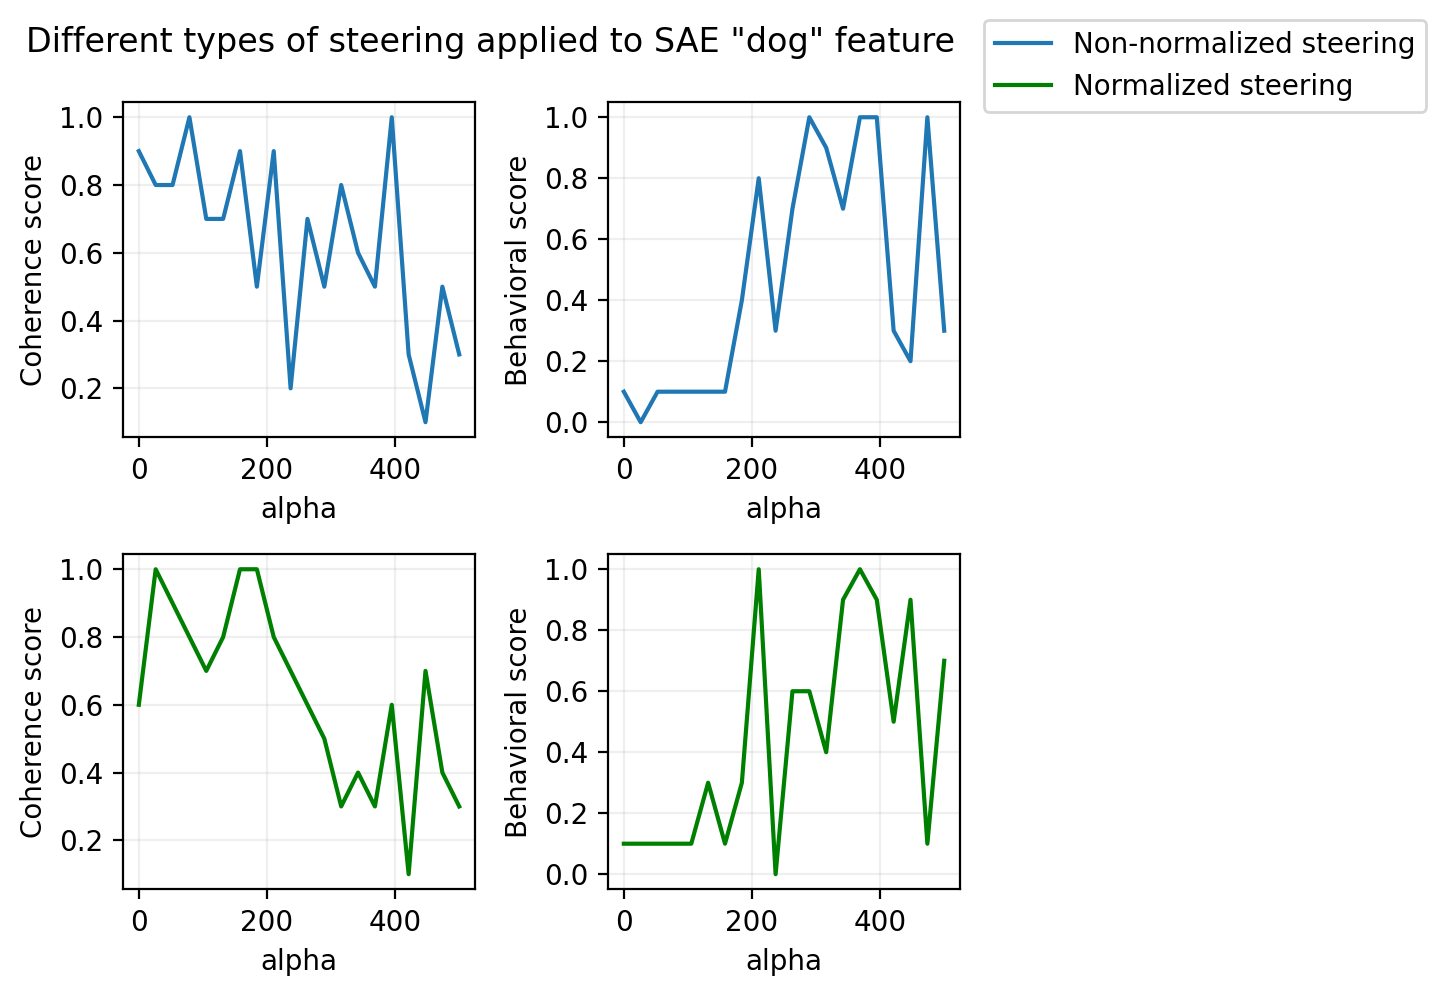

In [36]:
visualize_score_plots(non_normalized, normalized, "dog")